In [ ]:
%pip install torch

In [10]:
%pip install pydot

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [55]:
import tensorflow as tf
import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import keras, keras.layers as L
import keras.backend as K
import tqdm
import sys
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import pandas as pd
import os
import utils

In [56]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

In [57]:
# Importing Libraries for Text classification.
import string
import torch
from numpy import array
from numpy import argmax
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


In [14]:
%pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [58]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from pickle import dump
from tqdm import tqdm
from os import listdir, path

def extract_features_with_progress(directory):
    # load the model
    model = ResNet50()
    # Remove the classification layer
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    
    # Print the summary of the model
    print(model.summary())
    
    # extract features from each photo with progress bar
    features = {}
    for name in tqdm(listdir(directory), desc="Extracting Features"):
        # load an image from file
        filename = path.join(directory, name)
        image = load_img(filename, target_size=(224, 224))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the ResNet50 model
        image = preprocess_input(image)
        # get features
        feature = model.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
    
    return features

# extract features from all images with progress bar
directory = '/mnt/d/Ass3 dataset/Flickr8k_Dataset'
features = extract_features_with_progress(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features_final.pkl', 'wb'))


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_25[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

Extracting Features: 100%|██████████| 8091/8091 [13:49<00:00,  9.75it/s]


Extracted Features: 8091


In [59]:
import pickle

with open('/mnt/d/Ass3 dataset/features_final.pkl', 'rb') as f:
    features = pickle.load(f)

print(features.keys())

dict_keys(['1000268201_693b08cb0e', '1001773457_577c3a7d70', '1002674143_1b742ab4b8', '1003163366_44323f5815', '1007129816_e794419615', '1007320043_627395c3d8', '1009434119_febe49276a', '1012212859_01547e3f17', '1015118661_980735411b', '1015584366_dfcec3c85a', '101654506_8eb26cfb60', '101669240_b2d3e7f17b', '1016887272_03199f49c4', '1019077836_6fc9b15408', '1019604187_d087bf9a5f', '1020651753_06077ec457', '1022454332_6af2c1449a', '1022454428_b6b660a67b', '1022975728_75515238d8', '102351840_323e3de834', '1024138940_f1fefbdce1', '102455176_5f8ead62d5', '1026685415_0431cbf574', '1028205764_7e8df9a2ea', '1030985833_b0902ea560', '103106960_e8a41d64f8', '103195344_5d2dc613a3', '103205630_682ca7285b', '1032122270_ea6f0beedb', '1032460886_4a598ed535', '1034276567_49bb87c51c', '104136873_5b5d41be75', '1042020065_fb3d3ba5ba', '1042590306_95dea0916c', '1045521051_108ebc19be', '1048710776_bb5b0a5c7c', '1052358063_eae6744153', '105342180_4d4a40b47f', '1053804096_ad278b25f1', '1055623002_8195a43714'

In [60]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
filename = '/mnt/d/Ass3 dataset/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)
            
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()
 
filename = '/mnt/d/Ass3 dataset/Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptionsfinal.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [30]:
%pip install Pillow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [61]:
from keras.layers import add
from PIL import Image


In [82]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'sos ' + ' '.join(image_desc) + ' eos'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each description for the image
	for desc in desc_list:
		# encode the sequence
		seq = tokenizer.texts_to_sequences([desc])[0]
		# split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# store
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return array(X1), array(X2), array(y)

def define_model(vocab_size, max_length):
    # Feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # Sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    
    # Decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    # Compile model
    optimizer=keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    
    # Summarize model
    model.summary()
    
    # Plot model (optional)
    plot_model(model, to_file='modelfinal.png', show_shapes=True)
    
    return model





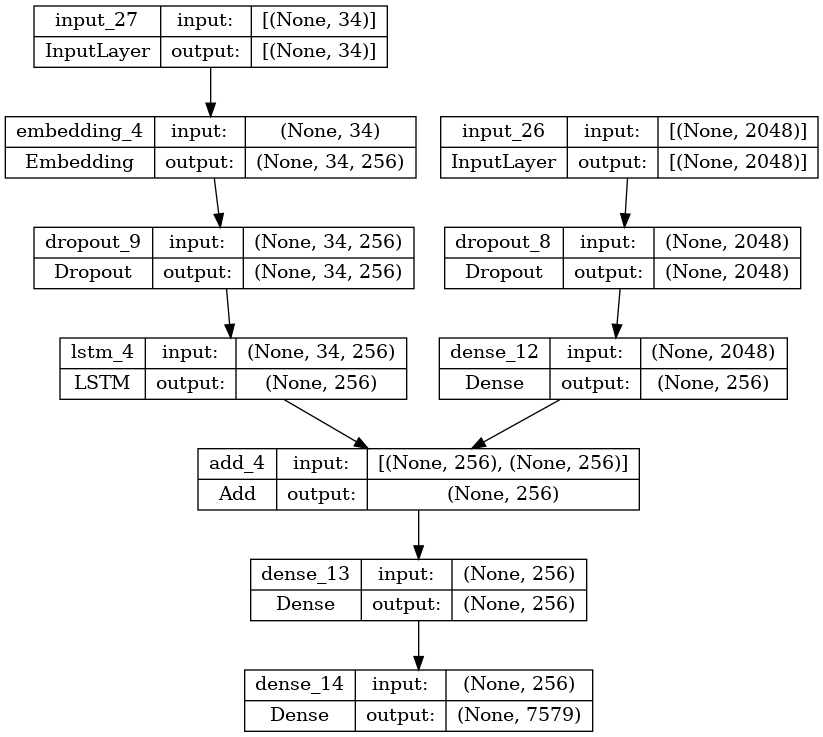

In [65]:
Image.open('/mnt/d/Ass3 dataset/modelfinal.png')

In [83]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
	# loop for ever over images
	while 1:
		for key, desc_list in descriptions.items():
			# retrieve the photo feature
			photo = photos[key][0]
			in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
			yield [[in_img, in_seq], out_word]
   
# load training dataset (6K)
filename = '/mnt/d/Ass3 dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/mnt/d/Ass3 dataset/descriptionsfinal.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('/mnt/d/Ass3 dataset/features_final.pkl', train)
print('Photos: train=%d' % len(train_features))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# define the model
model = define_model(vocab_size, max_length)
# train the model, run epochs manually and save after each epoch
epochs = 50
batch_size = 512
steps = len(train_descriptions)//batch_size
for i in range(epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
	# save model
	model.save('modelfinal1.keras')

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 7579
Description Length: 34
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 34)]                 0         []                            
                                                                                                  
 input_39 (InputLayer)       [(None, 2048)]               0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 34, 256)              1940224   ['input_40[0][0]']            
                                                                                                  
 dropout_14 (Dropout)        (None, 2048)                 0         ['input_39[0][0]']  

/tmp/ipykernel_1392287/969471674.py:39: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


11/11 [==============================] - 1s 79ms/step - loss: 0.1840


In [48]:
%pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 KB 9.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 KB 9.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [84]:
# Importing libraries for model evaluation
from numpy import argmax
from pickle import load
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import nltk
from nltk.translate.bleu_score import corpus_bleu

In [85]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'sos ' + ' '.join(image_desc) + ' eos'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'sos'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'eos':
			break
	return in_text

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    
    # Use tqdm to create a progress bar
    for key in tqdm(descriptions.keys(), desc="Evaluating"):
        desc_list = descriptions[key]

        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
 
 # prepare tokenizer on train set
 
# load training dataset (6K)
filename = '/mnt/d/Ass3 dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/mnt/d/Ass3 dataset/descriptionsfinal.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

# prepare test set
 
# load test set
filename = '/mnt/d/Ass3 dataset/Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('/mnt/d/Ass3 dataset/descriptionsfinal.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('/mnt/d/Ass3 dataset/features_final.pkl', test)
print('Photos: test=%d' % len(test_features))
 
# load the model
filename = '/mnt/d/Ass3 dataset/modelfinal1.keras'
model = load_model(filename)
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset: 6000
Descriptions: train=6000
Vocabulary Size: 7579
Description Length: 34
Dataset: 1000
Descriptions: test=1000
Photos: test=1000


Evaluating: 100%|██████████| 1000/1000 [08:55<00:00,  1.87it/s]
/home/toheed/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BLEU-1: 0.350958
BLEU-2: 0.097054
BLEU-3: 0.055524
BLEU-4: 0.000000


In [86]:
# Importing libraries
from keras.preprocessing.text import Tokenizer
from pickle import dump
 
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
 
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)
 
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'sos ' + ' '.join(image_desc) + ' eos'
			# store
			descriptions[image_id].append(desc)
	return descriptions
 
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc
 
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# load training dataset (6K)
filename = '/mnt/d/Ass3 dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('/mnt/d/Ass3 dataset/descriptionsfinal.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizerfinal.pkl', 'wb'))

Dataset: 6000
Descriptions: train=6000


In [69]:
print(model.layers[-2].output_shape)

(None, 256)


1/1 [==============================] - 1s 851ms/step


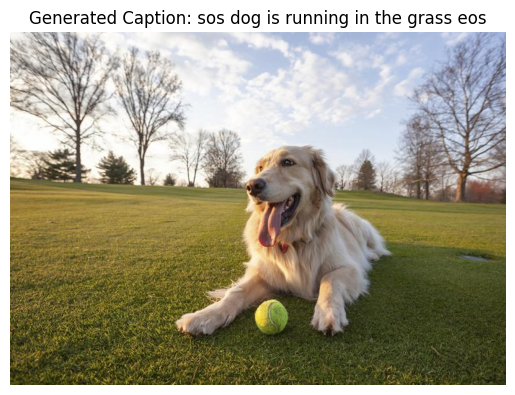

In [98]:
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import ResNet50, preprocess_input
from pickle import load
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained image captioning model
image_captioning_model = load_model('/mnt/d/Ass3 dataset/model_99.h5')

# Load the tokenizer
tokenizer = load(open('/mnt/d/Ass3 dataset/tokenizerfinal.pkl', 'rb'))

# Load the ResNet50 model for image feature extraction
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess and extract features from a custom image
def extract_features(filename, model):
    img = load_img(filename, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features

# Function to generate a caption for a given image file
def generate_caption(photo, model, tokenizer, max_length):
    in_text = 'sos'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'eos':
            break
    return in_text

# Function to map integer to word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Path to the custom image you want to generate a caption for
custom_image_path = '/mnt/d/Ass3 dataset/dogpark.jpg'

# Extract features from the custom image
photo = extract_features(custom_image_path, resnet_model)

# Set the maximum length of the generated caption
max_caption_length = 34

# Generate the caption
caption = generate_caption(photo, image_captioning_model, tokenizer, max_caption_length)

# Print the generated caption and display the image along with the caption
img = Image.open(custom_image_path)
plt.imshow(img)
plt.title('Generated Caption: ' + caption)
plt.axis('off')
plt.show()


In [108]:
import os
import pandas as pd
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.resnet50 import ResNet50, preprocess_input
from pickle import load
import numpy as np

# Load the pre-trained image captioning model
image_captioning_model = load_model('/mnt/d/Ass3 dataset/model_99.h5')

# Load the tokenizer
tokenizer = load(open('/mnt/d/Ass3 dataset/tokenizerfinal.pkl', 'rb'))

# Load the ResNet50 model for image feature extraction
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Load descriptions
filename = 'descriptionsfinal.txt'
doc = load_doc(filename)
descriptions = load_descriptions(doc)

# Function to preprocess and extract features from a custom image
def extract_features(filename, model):
    img = load_img(filename, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = model.predict(img_array)
    return features

# Function to generate a caption for a given image file
def generate_caption(photo, model, tokenizer, max_length):
    in_text = 'sos'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'eos':
            break
    return in_text

# Function to map integer to word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Path to the folder containing images
image_folder_path = '/mnt/d/Ass3 dataset/test'

# List to store image IDs and predicted captions
results = []

# Iterate over each image in the folder
for image_name in os.listdir(image_folder_path):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Construct the full path to the image
        image_path = os.path.join(image_folder_path, image_name)

        # Extract features from the custom image
        photo = extract_features(image_path, resnet_model)

        # Set the maximum length of the generated caption
        max_caption_length = 34

        # Generate the caption
        caption = generate_caption(photo, image_captioning_model, tokenizer, max_caption_length)

        # Append the image ID and predicted caption to the results list
        image_id = os.path.splitext(image_name)[0]  # Assuming image names are unique IDs

        # Print information for debugging
        print(f"Image ID: {image_id}, Caption: {caption}")

        results.append([image_id, caption])

# Convert the results list to a DataFrame
df = pd.DataFrame(results, columns=['image_id', 'predicted_caption'])

# Save the DataFrame to a CSV file
csv_file_path = '/mnt/d/Ass3 dataset/image_captions_folder.csv'
df.to_csv(csv_file_path, index=False)

print(f"Image captions saved to {csv_file_path}")


Image captions saved to /mnt/d/Ass3 dataset/image_captions_folder.csv
